<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/super_ress_new_still_pending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 45.3MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [3]:
path = untar_data(URLs.PETS)
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [4]:
path_hr = path/'images'
path_lr = path/'low_q'
path_mr = path/'med_q'

paths = [(path_lr, 96), (path_mr, 256)]

for i, j in paths:
  i.mkdir(exist_ok=True)

path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/low_q'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/med_q')]

In [5]:
il = ImageList.from_folder(path_hr)
test = il.items[0]

In [6]:
def resize_img(fn, _, path, size): 
  dest = path/fn.relative_to(path_hr)
  img = PIL.Image.open(fn)
  targ_sz = resize_to(img, size, use_min= True)
  img = img.resize(targ_sz,
  resample = PIL.Image.BILINEAR).convert('RGB')
  img.save(dest, quality = 60)

In [7]:
for i in paths:
  parallel(partial(resize_img, path = i[0], size = i[1]), il.items)

In [8]:
test.name;
path_hr

PosixPath('/root/.fastai/data/oxford-iiit-pet/images')

In [10]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct().label_from_func(lambda x: path_hr/x.name)

In [11]:
size, bs = 128, 32

def get_data(bs, size):
  data = src.transform(get_transforms(max_zoom = 2.), tfm_y = True, size = size).databunch(bs = bs).normalize(imagenet_stats)
  data.c = 3
  return data

data = get_data(bs, size)

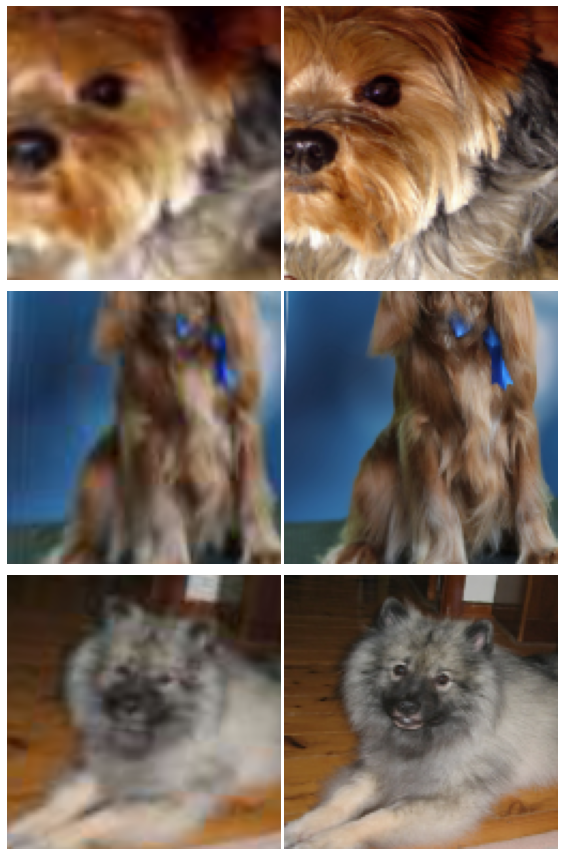

In [12]:
data.show_batch(rows = 3)

In [13]:
arch = models.resnet34

In [14]:
vgg = vgg16_bn()

In [15]:
x = data.valid_ds[0][1]
x.data

tensor([[[0.6814, 0.6951, 0.2284,  ..., 0.7029, 0.7451, 0.7216],
         [0.6287, 0.5593, 0.2597,  ..., 0.6355, 0.7353, 0.6855],
         [0.3372, 0.4091, 0.2345,  ..., 0.4961, 0.6993, 0.3701],
         ...,
         [0.3350, 0.3688, 0.2955,  ..., 0.0300, 0.1571, 0.2331],
         [0.2423, 0.1970, 0.1556,  ..., 0.0346, 0.1575, 0.2804],
         [0.1284, 0.1431, 0.1637,  ..., 0.0402, 0.1647, 0.2869]],

        [[0.8304, 0.8804, 0.3824,  ..., 0.9010, 0.8912, 0.8928],
         [0.8097, 0.7312, 0.3054,  ..., 0.8127, 0.8870, 0.8326],
         [0.4382, 0.4512, 0.2711,  ..., 0.6780, 0.8691, 0.4336],
         ...,
         [0.4115, 0.4172, 0.3569,  ..., 0.0211, 0.1623, 0.2468],
         [0.2961, 0.2499, 0.1890,  ..., 0.0268, 0.1504, 0.2666],
         [0.1510, 0.1725, 0.1931,  ..., 0.0245, 0.1431, 0.2732]],

        [[0.8794, 0.9480, 0.4902,  ..., 0.9902, 0.9755, 0.9908],
         [0.9181, 0.7950, 0.2675,  ..., 0.8492, 0.9765, 0.9120],
         [0.4502, 0.4169, 0.1629,  ..., 0.6946, 0.8993, 0.

In [16]:
y = vgg.features(x.data[None])
y.shape

torch.Size([1, 512, 4, 4])

In [17]:
z = vgg(x.data[None])
z.shape
z[0][:10]

tensor([-0.7363, -0.7172,  0.8522, -1.1629,  1.0402,  1.0979,  0.6619, -0.2899,
        -0.1540, -0.1184], grad_fn=<SliceBackward>)

In [18]:
layers = vgg.features.eval()
type(layers)
children(layers), len(children(layers))

([Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
  ReLU(inplace=True),
  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
  ReLU(inplace=True),
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
  Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
  ReLU(inplace=True),
  Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
  ReLU(inplace=True),
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
  Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
  BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [19]:
features = vgg.features.cuda().eval()
layer_ids = []
layers = []
for l_index, l in enumerate(children(features)):
  if isinstance(l, nn.MaxPool2d):
    layer_ids.append(l_index - 1)
    layers.append(l)
print(layer_ids)

[5, 12, 22, 32, 42]


In [20]:
layers = [children(features)[i-1] for i in layer_ids]
layers
new_x = layers[0]

for i in new_x.parameters():
  print(type(i))
  p = i

<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>


In [21]:
new_x

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [22]:
!pip install ipdb 
from ipdb import set_trace as st

  Created wheel for ipdb: filename=ipdb-0.13.3-cp36-none-any.whl size=10848 sha256=91a22a292e655ff984463fd048aea8d825a8580e673b0b985318a71a10ab8b4b
  Stored in directory: /root/.cache/pip/wheels/75/00/30/4169bcc3643f0cf946dcf37af1b71364b390c4df91da02b03c
Successfully built ipdb


In [23]:
base_loss = F.l1_loss

In [24]:
class FeatureLoss(nn.Module):
  def __init__(self, base_model, base_loss, layer_ids, layer_wgts):
    super().__init__()

    self.m_feat = base_model
    self.loss_fn = base_loss
    self.wgts = layer_wgts
    self.layer_ids = layer_ids

    self.loss_features = [base_model[i] for i in self.layer_ids]
    self.hook_loss = hook_outputs(self.loss_features, detach= False)

    self.metric_names = ['Pixel_loss'] + [f'layer_loss_{i}' for i in self.layer_ids]

  def make_features(self, x, clone = False):
    self.m_feat(x)
    return [(o.clone() if clone else o) for o in self.hook_loss.stored]
  
  def forward(self, input, target):
    targ_feat = self.make_features(target, True)
    in_feat = self.make_features(input)

    pixel_loss = self.loss_fn(input, target)
    feature_losses = [self.loss_fn(inp, targ)*w for inp, targ, w in zip(in_feat, targ_feat, self.wgts)]

    self.losses = [pixel_loss, *feature_losses]
    self.metrics = dict(zip(self.metric_names, self.losses))

    return sum(self.losses)
  
  def __del__(self):
    self.hook_loss.remove()

In [25]:
loss_fn = FeatureLoss(vgg.features.cuda().eval(), base_loss, layer_ids, [2, 4, 6, 12, 5])

In [26]:
x, y = data.valid_ds[0]
x, y = x.data[None].cuda(), y.data[None].cuda()
loss = loss_fn(x,y)

In [27]:
learn = unet_learner(data, arch=arch, loss_func = loss_fn, callback_fns = LossMetrics, blur= True, norm_type = NormType.Weight, wd = 1e-3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [28]:
learn.lr_find()

epoch,train_loss,valid_loss,Pixel_loss,layer_loss_5,layer_loss_12,layer_loss_22,layer_loss_32,layer_loss_42,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


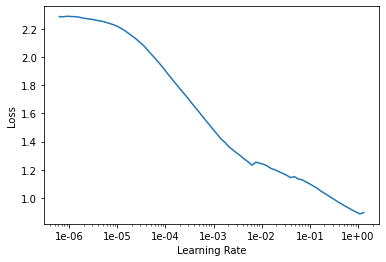

In [29]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(10, slice(3e-04, 1e-03))

epoch,train_loss,valid_loss,Pixel_loss,layer_loss_5,layer_loss_12,layer_loss_22,layer_loss_32,layer_loss_42,time
0,0.237061,0.227119,0.069972,0.022895,0.033595,0.036172,0.047465,0.017020,01:20
1,0.159175,0.168978,0.048846,0.016414,0.024934,0.027507,0.037555,0.013722,01:18
2,0.145181,0.131808,0.037274,0.012800,0.019705,0.021714,0.029475,0.010840,01:19
3,0.128083,0.118467,0.032164,0.011385,0.017854,0.019774,0.027222,0.010069,01:19
4,0.120035,0.118578,0.031819,0.011330,0.017902,0.019925,0.027446,0.010156,01:19
5,0.114886,0.111641,0.030067,0.010687,0.016788,0.018645,0.025842,0.009611,01:18
6,0.112058,0.108977,0.029012,0.010380,0.016391,0.018294,0.025426,0.009474,01:19
7,0.109067,0.107169,0.028404,0.010185,0.016134,0.018018,0.025072,0.009355,01:19
8,0.107953,0.106800,0.028335,0.010163,0.016082,0.017947,0.024959,0.009314,01:19
9,0.109166,0.106415,0.028211,0.010123,0.016021,0.017880,0.024888,0.009292,01:19


In [32]:
def train_model(save_name, lrs, pct_start = 0.9, epocs = 10):
  learn.fit_one_cycle(epocs, lrs, pct_start = pct_start)
  learn.save(save_name)
  learn.show_results(rows = 2, imgsize = 5)

epoch,train_loss,valid_loss,Pixel_loss,layer_loss_5,layer_loss_12,layer_loss_22,layer_loss_32,layer_loss_42,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


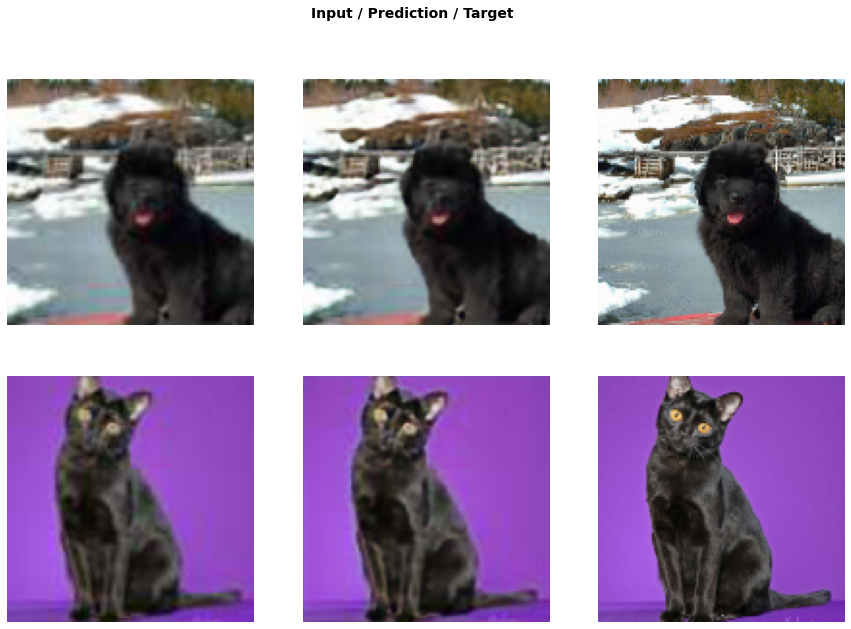

In [33]:
learn.show_results(rows = 2, imgsize = 5)
learn.save('stage_1')
learn.unfreeze()
learn.lr_find()

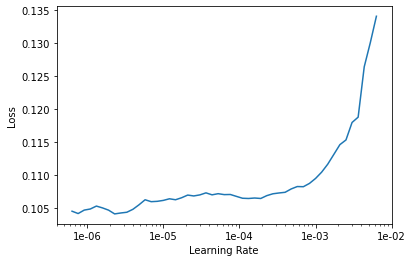

In [34]:
learn.recorder.plot()

epoch,train_loss,valid_loss,Pixel_loss,layer_loss_5,layer_loss_12,layer_loss_22,layer_loss_32,layer_loss_42,time
0,0.108418,0.106363,0.028176,0.010113,0.016013,0.017878,0.024890,0.009293,01:21
1,0.107887,0.106304,0.028138,0.010098,0.016007,0.017879,0.024889,0.009293,01:21
2,0.109369,0.106194,0.028106,0.010086,0.015988,0.017863,0.024865,0.009284,01:21
3,0.108744,0.106151,0.028125,0.010098,0.015984,0.017837,0.024833,0.009273,01:21
4,0.107341,0.106099,0.028112,0.010096,0.015978,0.017826,0.024818,0.009269,01:21
5,0.108557,0.105872,0.028012,0.010057,0.015939,0.017808,0.024794,0.009262,01:21
6,0.107622,0.105775,0.027950,0.010044,0.015927,0.017798,0.024794,0.009262,01:21
7,0.106442,0.105489,0.027834,0.009998,0.015886,0.017771,0.024752,0.009247,01:21
8,0.107588,0.105462,0.027901,0.010021,0.015884,0.017733,0.024697,0.009226,01:21
9,0.106562,0.105132,0.027707,0.009965,0.015826,0.017723,0.024686,0.009226,01:21


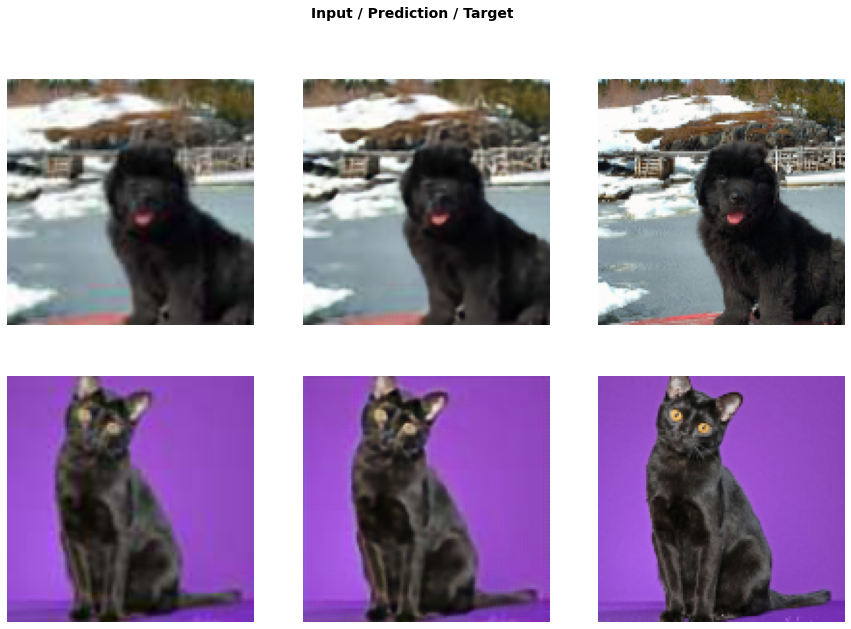

In [35]:
train_model('stage_2', slice(1e-06, 2e-04), epocs  = 20)

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageImageList
Image (3, 12, 12),Image (3, 12, 12),Image (3, 12, 12),Image (3, 12, 12),Image (3, 12, 12)
y: ImageList
Image (3, 12, 12),Image (3, 12, 12),Image (3, 12, 12),Image (3, 12, 12),Image (3, 12, 12)
Path: /root/.fastai/data/oxford-iiit-pet/low_q;

Valid: LabelList (1478 items)
x: ImageImageList
Image (3, 12, 12),Image (3, 12, 12),Image (3, 12, 12),Image (3, 12, 12),Image (3, 12, 12)
y: ImageList
Image (3, 12, 12),Image (3, 12, 12),Image (3, 12, 12),Image (3, 12, 12),Image (3, 12, 12)
Path: /root/.fastai/data/oxford-iiit-pet/low_q;

Test: None

4

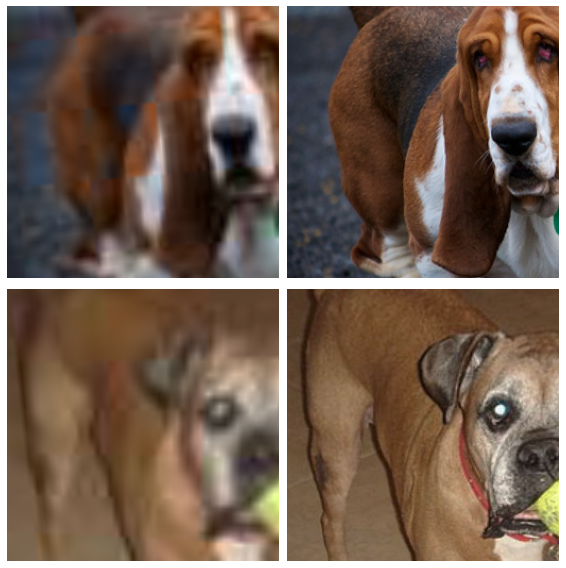

In [45]:
'''
size, bs = 128, 32

def get_data(bs, size):
  data = src.transform(get_transforms(max_zoom = 2.), tfm_y = True, size = size).databunch(bs = bs).normalize(imagenet_stats)
  data.c = 3
  return data
'''
learn.load('stage_2')
learn.freeze()

new_data = get_data(12, size*2)
new_data.show_batch(rows = 2)
learn.data = new_data
gc.collect()

# learn.fit_one_cycle(5, slice(1e-3), pct_start = 0.9)
# learn.show_results(rows = 2, imgsize = 5)


epoch,train_loss,valid_loss,Pixel_loss,layer_loss_5,layer_loss_12,layer_loss_22,layer_loss_32,layer_loss_42,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


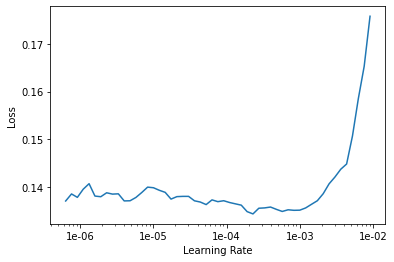

In [47]:
learn.data = new_data
learn.load('stage_2')
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,Pixel_loss,layer_loss_5,layer_loss_12,layer_loss_22,layer_loss_32,layer_loss_42,time
0,0.131700,0.127568,0.033147,0.011882,0.019154,0.021514,0.030043,0.011829,05:18
1,0.131786,0.128394,0.033355,0.011931,0.019272,0.021676,0.030258,0.011902,05:15
2,0.132349,0.130471,0.033309,0.011834,0.019518,0.022294,0.031215,0.012301,05:15
3,0.133591,0.131164,0.034998,0.012597,0.019880,0.021793,0.030105,0.011791,05:15
4,0.132834,0.130253,0.034214,0.012236,0.019660,0.021881,0.030355,0.011908,05:15
5,0.131422,0.130435,0.034553,0.012349,0.019600,0.021797,0.030266,0.011870,05:15
6,0.134367,0.128714,0.033723,0.012043,0.019333,0.021608,0.030158,0.011849,05:15
7,0.132370,0.128652,0.033193,0.011891,0.019332,0.021770,0.030469,0.011998,05:15
8,0.131096,0.131859,0.035822,0.012858,0.019906,0.021692,0.029892,0.011689,05:15
9,0.130000,0.124367,0.032763,0.011805,0.018769,0.020780,0.028887,0.011363,05:15


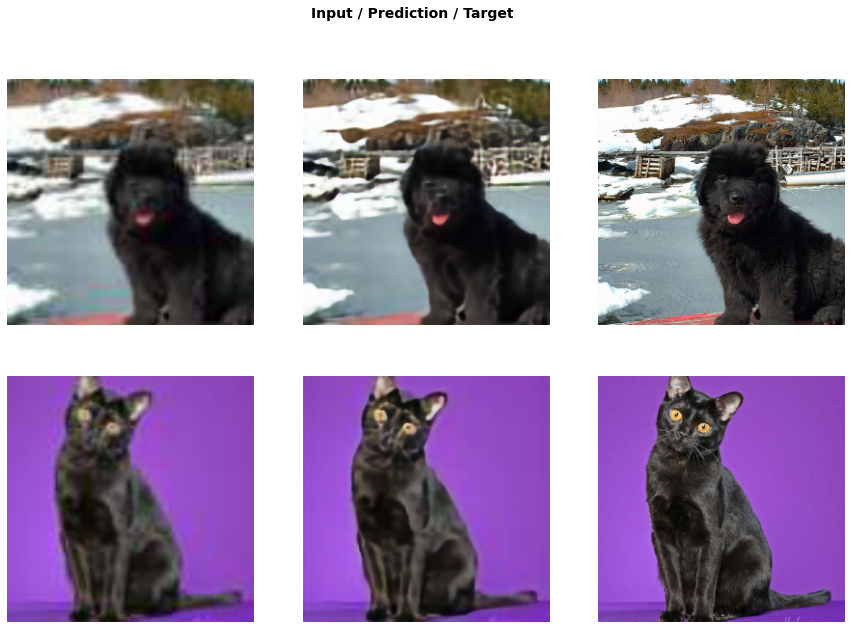

In [48]:
'''
def train_model(save_name, lrs, pct_start = 0.9, epocs = 10):
  learn.fit_one_cycle(epocs, lrs, pct_start = pct_start)
  learn.save(save_name)
  learn.show_results(rows = 2, imgsize = 5)
'''
train_model('stage_3', lrs = slice(1e-05, 1e-03), epocs = 10)